In [ ]:
#Imports
import os
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding, Input, Dropout, Conv1D, GlobalMaxPooling1D, LSTM, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
! pip install -q kaggle
from google.colab import files 
files.upload() #aqui faz o upload do kaggle.json que voce gerou. Ver link acima.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pedrozeola","key":"7a3378e177ad4bdc2bc66a11d6ca4deb"}'}

In [ ]:
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
if os.path.exists('portuguese-tweets-for-sentiment-analysis.zip') == False:
  !kaggle datasets download -d augustop/portuguese-tweets-for-sentiment-analysis
  !unzip portuguese-tweets-for-sentiment-analysis.zip
  

 98% 219M/224M [00:04<00:00, 77.5MB/s]
100% 224M/224M [00:04<00:00, 57.1MB/s]
Archive:  portuguese-tweets-for-sentiment-analysis.zip
  inflating: NoThemeTweets.csv       
  inflating: TestDatasets/Test.csv   
  inflating: TestDatasets/Test3classes.csv  
  inflating: TestDatasets/TestTema.csv  
  inflating: TrainingDatasets/Train100.csv  
  inflating: TrainingDatasets/Train200.csv  
  inflating: TrainingDatasets/Train300.csv  
  inflating: TrainingDatasets/Train3Classes.csv  
  inflating: TrainingDatasets/Train400.csv  
  inflating: TrainingDatasets/Train50.csv  
  inflating: TrainingDatasets/Train500.csv  
  inflating: TrainingDatasets/TrainTema.csv  
  inflating: TweetsNeutralHash.csv   
  inflating: TweetsNeutralNews.csv   
  inflating: TweetsWithTheme.csv     
  inflating: testdatasets/Test.csv   
  inflating: testdatasets/Test3classes.csv  
  inflating: testdatasets/TestTema.csv  
  inflating: trainingdatasets/Train100.csv  
  inflating: trainingdatasets/Train200.csv  
  inflating:

In [ ]:
def load_data(file_train = 'trainingdatasets/Train3Classes.csv', file_test = 'testdatasets/Test3classes.csv'):
    train = pd.read_csv(
        file_train, delimiter=';')

    test = pd.read_csv(
        file_test, delimiter=';')
    
    return train, test

train, test = load_data()
train.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


In [ ]:
train.tail()

,id,tweet_text,tweet_date,sentiment,query_used
99995,1030468564715794432,Confira esta vaga na Senac-RS: Editor De Video...,Fri Aug 17 14:57:05 +0000 2018,2,#oportunidade
99996,1030468147353210881,Confira esta vaga na Grupo SABEMI: Assistente ...,Fri Aug 17 14:55:26 +0000 2018,2,#oportunidade
99997,1030467484766359552,Confira esta vaga na Groupe L’OCCITANE: Gerent...,Fri Aug 17 14:52:48 +0000 2018,2,#oportunidade
99998,1030466921702076416,"Está no ar o CandidatoWEB, seu novo portal de ...",Fri Aug 17 14:50:33 +0000 2018,2,#trabalho
99999,1027373651585249280,Anavitória industrializa pop folk em álbum pau...,Thu Aug 09 01:59:00 +0000 2018,2,g1


In [ ]:
X_train = train.loc[:, 'tweet_text'].values
y_train = train.loc[:, 'sentiment'].values

X_test = test.loc[:, 'tweet_text'].values
y_test = test.loc[:, 'sentiment'].values

print("X_train:", X_train[0])
print("y_train:", y_train[0])
print("X_test:", X_test[0])
print("y_test:", y_test[0])

X_train: @Laranjito76 A pessoa certa para isso seria o vale e azevedo :)
y_train: 1
X_test: @Gazo1a Nossa! Muito obrigada :)
y_test: 1


# Preprocessing

---



In [ ]:
import re

In [ ]:
def _remove_url(data):
    ls = []
    words = ''
    regexp1 = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    regexp2 = re.compile('www?.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    
    for line in data:
        urls = regexp1.findall(line)

        for u in urls:
            line = line.replace(u, ' ')

        urls = regexp2.findall(line)

        for u in urls:
            line = line.replace(u, ' ')
            
        ls.append(line)
    return ls

In [ ]:
X_train = _remove_url(X_train)
X_test = _remove_url(X_test)

In [ ]:
def _remove_regex(data, regex_pattern):
    ls = []
    words = ''
    
    for line in data:
        matches = re.finditer(regex_pattern, line)
        
        for m in matches: 
            line = re.sub(m.group().strip(), '', line)

        ls.append(line)

    return ls

In [ ]:
# hashtags
regex_pattern = '#[\w]*'
X_train = _remove_regex(X_train, regex_pattern)
X_test = _remove_regex(X_test, regex_pattern)

In [ ]:
# notations
regex_pattern = '@[\w]*'
X_train = _remove_regex(X_train, regex_pattern)
X_test = _remove_regex(X_test, regex_pattern)

In [ ]:
for i in range(0, 5):
    print(X_train[i])

 A pessoa certa para isso seria o vale e azevedo :)
 Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)
Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina   Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D
aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também :)  
Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele :))  


In [ ]:
emoticon_list = {':))': 'positive_emoticon', ':)': 'positive_emoticon', ':D': 'positive_emoticon', ':(': 'negative_emoticon', ':((': 'negative_emoticon', '8)': 'neutral_emoticon'}

In [ ]:
def _replace_emoticons(data, emoticon_list):
    ls = []

    for line in data:
        for exp in emoticon_list:
            line = line.replace(exp, emoticon_list[exp])

        ls.append(line)

    return ls

In [ ]:
X_train = _replace_emoticons(X_train, emoticon_list)
X_test = _replace_emoticons(X_test, emoticon_list)

In [ ]:
for i in range(0, 5):
    print(X_train[i])

 A pessoa certa para isso seria o vale e azevedo positive_emoticon
 Para mim, é precisamente o contrário positive_emoticon Vem a chuva e vem a boa disposição positive_emoticon
Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina   Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional positive_emoticon
aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também positive_emoticon  
Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele positive_emoticon  


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize

def _tokenize_text(data):
    ls = []

    for line in data:
        tokens = wordpunct_tokenize(line)
        ls.append(tokens)

    return ls

In [ ]:
X_train_tokens = _tokenize_text(X_train)
X_test_tokens = _tokenize_text(X_test)

In [ ]:
for i in range(0, 5):
    print(X_train_tokens[i])

['A', 'pessoa', 'certa', 'para', 'isso', 'seria', 'o', 'vale', 'e', 'azevedo', 'positive_emoticon']
['Para', 'mim', ',', 'é', 'precisamente', 'o', 'contrário', 'positive_emoticon', 'Vem', 'a', 'chuva', 'e', 'vem', 'a', 'boa', 'disposição', 'positive_emoticon']
['Vou', 'fazer', 'um', 'video', 'hoje', '...', 'estou', 'pensando', 'em', 'falar', 'um', 'pouco', 'sobre', 'o', 'novo', 'meta', 'do', 'CSGO', 'e', 'sobre', 'a', 'pagina', 'Alguem', 'tem', 'uma', 'sugestao', '?', 'Queria', 'falar', 'sobre', 'algo', 'do', 'cenario', 'nacional', 'positive_emoticon']
['aaaaaaaa', 'amei', 'tanto', 'essas', 'polaroids', ',', 'nem', 'sei', 'expressar', 'o', 'quanto', 'eu', 'to', 'apaixonada', 'de', 'vdd', '✨💖🎈🎉🎊', 'espero', 'que', 'outras', 'pessoas', 'consigam', 'ganhar', 'também', 'positive_emoticon']
['Valoriza', 'o', 'coração', 'do', 'menininho', 'que', 'vc', 'tem', '.', 'Ele', 'é', 'diferente', '.', 'O', 'faça', 'sorrir', 'e', 'ter', 'certeza', 'disso', '❤️', '—', 'Eu', 'valorizo', 'todo', 'mundo',

In [ ]:
def _apply_standardization(tokens, std_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() in std_list:
                word = std_list[word.lower()]
                
            new_tokens.append(word) 
            
        ls.append(new_tokens)

    return ls

In [ ]:
std_list = {'eh': 'é', 'vc': 'você', 'vcs': 'vocês','tb': 'também', 'tbm': 'também', 'obg': 'obrigado', 'gnt': 'gente', 'q': 'que', 'n': 'não', 'cmg': 'comigo', 'p': 'para', 'ta': 'está', 'to': 'estou', 'vdd': 'verdade'}

In [ ]:
print(X_train[4], X_train[35008])

Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele positive_emoticon    Infelizmente isso acontece cmg tb.. negative_emoticon


In [ ]:
X_train_tokens = _apply_standardization(X_train_tokens, std_list)
X_test_tokens = _apply_standardization(X_test_tokens, std_list)

In [ ]:
print(X_train_tokens[4], X_train_tokens[35008])

['Valoriza', 'o', 'coração', 'do', 'menininho', 'que', 'você', 'tem', '.', 'Ele', 'é', 'diferente', '.', 'O', 'faça', 'sorrir', 'e', 'ter', 'certeza', 'disso', '❤️', '—', 'Eu', 'valorizo', 'todo', 'mundo', 'na', 'minha', 'vida', ',', 'não', 'vai', 'ser', 'diferente', 'com', 'ele', 'positive_emoticon'] ['Infelizmente', 'isso', 'acontece', 'comigo', 'também', '..', 'negative_emoticon']


In [ ]:
def _remove_stopwords(tokens, stopword_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() not in stopword_list:
                new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [ ]:
stopword_list = []
nltk_stopwords = nltk.corpus.stopwords.words('portuguese')

In [ ]:
df = pd.read_fwf('/content/stopwords.txt', header = None)
df.head(10)

,0
0,de
1,a
2,o
3,que
4,e
5,do
6,da
7,em
8,um
9,para


In [ ]:

custom_stopwords = df.values.tolist()

custom_stopwords = [s[0] for s in custom_stopwords]

In [ ]:
stopword_list.append('é')
stopword_list.append('vou')
stopword_list.append('que')
stopword_list.append('tão')
stopword_list.append('...')
stopword_list.append('«')
stopword_list.append('➔')
stopword_list.append('|')
stopword_list.append('»')
stopword_list.append('uai')

In [ ]:
stopword_list.extend(nltk_stopwords)
stopword_list.extend(custom_stopwords)

In [ ]:
stopword_list = list(set(stopword_list))

In [ ]:
X_train_tokens = _remove_stopwords(X_train_tokens, stopword_list)
X_test_tokens = _remove_stopwords(X_test_tokens, stopword_list)

In [ ]:
for i in range(0, 5):
    print(X_train_tokens[i])

['pessoa', 'certa', 'vale', 'azevedo', 'positive_emoticon']
['mim', ',', 'precisamente', 'contrário', 'positive_emoticon', 'Vem', 'chuva', 'vem', 'boa', 'disposição', 'positive_emoticon']
['fazer', 'video', 'hoje', 'pensando', 'falar', 'pouco', 'sobre', 'novo', 'meta', 'CSGO', 'sobre', 'pagina', 'Alguem', 'sugestao', '?', 'Queria', 'falar', 'sobre', 'algo', 'cenario', 'nacional', 'positive_emoticon']
['aaaaaaaa', 'amei', 'tanto', 'polaroids', ',', 'sei', 'expressar', 'quanto', 'apaixonada', 'verdade', '✨💖🎈🎉🎊', 'espero', 'outras', 'pessoas', 'consigam', 'ganhar', 'positive_emoticon']
['Valoriza', 'coração', 'menininho', '.', 'diferente', '.', 'faça', 'sorrir', 'certeza', 'disso', '❤️', '—', 'valorizo', 'todo', 'mundo', 'vida', ',', 'vai', 'diferente', 'positive_emoticon']


In [ ]:
def _apply_stemmer(tokens):
    ls = []
    stemmer = nltk.stem.RSLPStemmer()

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            word = str(stemmer.stem(word))
            new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls
import nltk
nltk.download('rslp')

X_train_tokens = _apply_stemmer(X_train_tokens)
X_test_tokens = _apply_stemmer(X_test_tokens)

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [ ]:
for i in range(0, 5):
    print(X_train_tokens[i])

['pesso', 'cert', 'val', 'azeved', 'positive_emoticon']
['mim', ',', 'precis', 'contr', 'positive_emoticon', 'vem', 'chuv', 'vem', 'boa', 'dispos', 'positive_emoticon']
['faz', 'vide', 'hoj', 'pens', 'fal', 'pouc', 'sobr', 'nov', 'met', 'csg', 'sobr', 'pagin', 'algu', 'sugesta', '?', 'quer', 'fal', 'sobr', 'alg', 'cenari', 'nacion', 'positive_emoticon']
['aaaaaaa', 'ame', 'tant', 'polaroid', ',', 'sei', 'express', 'quant', 'apaixon', 'verdad', '✨💖🎈🎉🎊', 'esper', 'outr', 'pesso', 'consig', 'ganh', 'positive_emoticon']
['valoriz', 'coraçã', 'menin', '.', 'difer', '.', 'faç', 'sorr', 'cert', 'diss', '❤️', '—', 'valoriz', 'tod', 'mund', 'vid', ',', 'vai', 'difer', 'positive_emoticon']


In [ ]:
def _get_freq_dist_list(tokens):
    ls = []

    for tk_line in tokens:
        for word in tk_line:
            ls.append(word)

    return ls

In [ ]:
from nltk import FreqDist
fd_list = _get_freq_dist_list(X_train_tokens)
fdist = FreqDist(fd_list)
print(fdist)

<FreqDist with 36925 samples and 985541 outcomes>


In [ ]:
most_common = fdist.most_common(25)
print(most_common)

[(',', 46143), ('negative_emoticon', 33232), ('positive_emoticon', 31038), ('.', 22999), (':', 10575), ('-', 10302), ('!', 8718), ('pra', 7604), ('?', 6638), ('quer', 5631), ('(', 5150), ('dia', 5121), ('faz', 4503), ("'", 4422), (';', 4336), ('vai', 4228), ('"', 3926), ('diz', 3853), ('tod', 3809), ('fic', 3689), ('bolsonar', 3442), ('pod', 3398), ('&', 3249), ('fal', 3207), ('bem', 3153)]


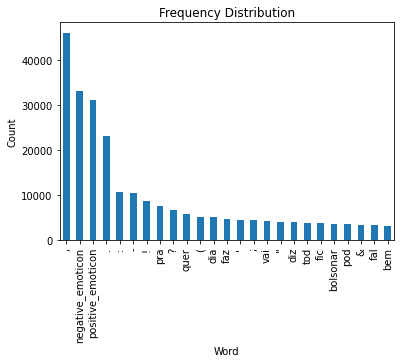

In [ ]:
series = pd.Series(data=[v for k, v in most_common], index=[k for k, v in most_common], name='')
ax = series.plot(kind='bar', title='Frequency Distribution')
ax.set_xlabel('Word')
ax.set_ylabel('Count')
plt.show()

In [ ]:
X_train_tokens = pad_sequences(X_train_tokens, dtype=object)
X_test_tokens = pad_sequences(X_test_tokens, dtype=object)

In [ ]:
print(X_train_tokens[0])
print(X_train_tokens[2000])
print(X_train_tokens[3000])
print(X_train_tokens[99996])

[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 'pesso'
 'cert' 'val' 'azeved' 'positive_emoticon']
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 'amo' 'td' 'forç' ',' 'promet' 'sempr' 'am' ','
 'promet' 'fal' 'pessoal' ':' 'velh' '❤️❤️❤️❤️']
[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.

# Building the weight matrix

In [ ]:
#Word Embeddings em português: http://nilc.icmc.usp.br/nilc/index.php/repositorio-de-word-embeddings-do-nilc

if os.path.exists('glove.6B.zip') == False:
  !wget http://nlp.stanford.edu/data/glove.6B.zip
  !unzip -o glove.6B.zip

glove_embeddings_index = {}
with io.open('glove.6B.300d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:],dtype='float32')
        glove_embeddings_index[word] = coefs

# Building the weight matrix 

--2021-12-20 01:05:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-20 01:05:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-20 01:05:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
################################################################################
# Continue.....
################################################################################
